In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fastEDM import edm

NUM_THREADS = 8

In [2]:
df = pd.read_csv("University of NSW Market Trends - 20210818T145801.csv", low_memory=False)

df = df.loc[pd.notna(df["postcode"])]
df["postcode"] = df["postcode"].astype(int)

df["value_at_date"] = pd.to_datetime(df["value_at_date"])
df

,state,sa3_name16,sa4_name16,postcode,property_type,value_at_date,Volume of new rental listings (1 month),Hedonic Rental Yields,Hedonic Home Value Index,Volume of sales (1 month)
0,NT,Darwin City,Darwin,800,Houses,1980-01-31,NaN,0.0000,154.6729,NaN
1,NT,Darwin City,Darwin,800,Houses,1980-02-29,NaN,0.0000,154.6729,NaN
2,NT,Darwin City,Darwin,800,Houses,1980-03-31,NaN,0.0000,154.6729,NaN
3,NT,Darwin City,Darwin,800,Houses,1980-04-30,NaN,0.0000,154.6729,NaN
4,NT,Darwin City,Darwin,800,Houses,1980-05-31,NaN,0.0000,154.6729,NaN
...,...,...,...,...,...,...,...,...,...,...
2430904,TAS,West Coast,West and North West,7470,Units,2021-01-31,NaN,0.1163,136.2794,NaN
2430905,TAS,West Coast,West and North West,7470,Units,2021-02-28,2.0,0.1108,136.8831,NaN
2430906,TAS,West Coast,West and North West,7470,Units,2021-03-31,NaN,0.1005,142.0042,NaN
2430907,TAS,West Coast,West and North West,7470,Units,2021-04-30,NaN,0.0886,150.4537,NaN


In [3]:
#| label: reduce-dataset
df = df.loc[df["state"] == "NSW"]
df = df.loc[df["value_at_date"].dt.year >= 2010]
df = df.loc[df["property_type"] == "Houses"]

# Rename often-used "Hedonic Home Value Index" to HPI (read: home price index).
df.rename(columns={"Hedonic Home Value Index": "HPI"}, inplace=True)

In [4]:
# "time" column holds the # months since 1980
df["time"] = (df["value_at_date"].dt.year-1980)*12 + df["value_at_date"].dt.month

In [5]:
# https://www.matthewproctor.com/australian_postcodes
australian_postcodes = pd.read_csv("australian_postcodes.csv")

In [6]:
#| label: remove-postcodes-with-few-observations
counts = df["postcode"].value_counts()
boring_postcodes = list(counts[counts < 12].index)

print(f"# Postcodes with few observations: {len(boring_postcodes)}")
print(f"Postcodes with few observations: {boring_postcodes}")

df = df[~df["postcode"].isin(boring_postcodes)]

# Postcodes with few observations: 1
Postcodes with few observations: [2625]


In [7]:
#| label: amount-of-boring-data
np.mean(np.diff(df["HPI"]) == 0)

0.024843838727995456

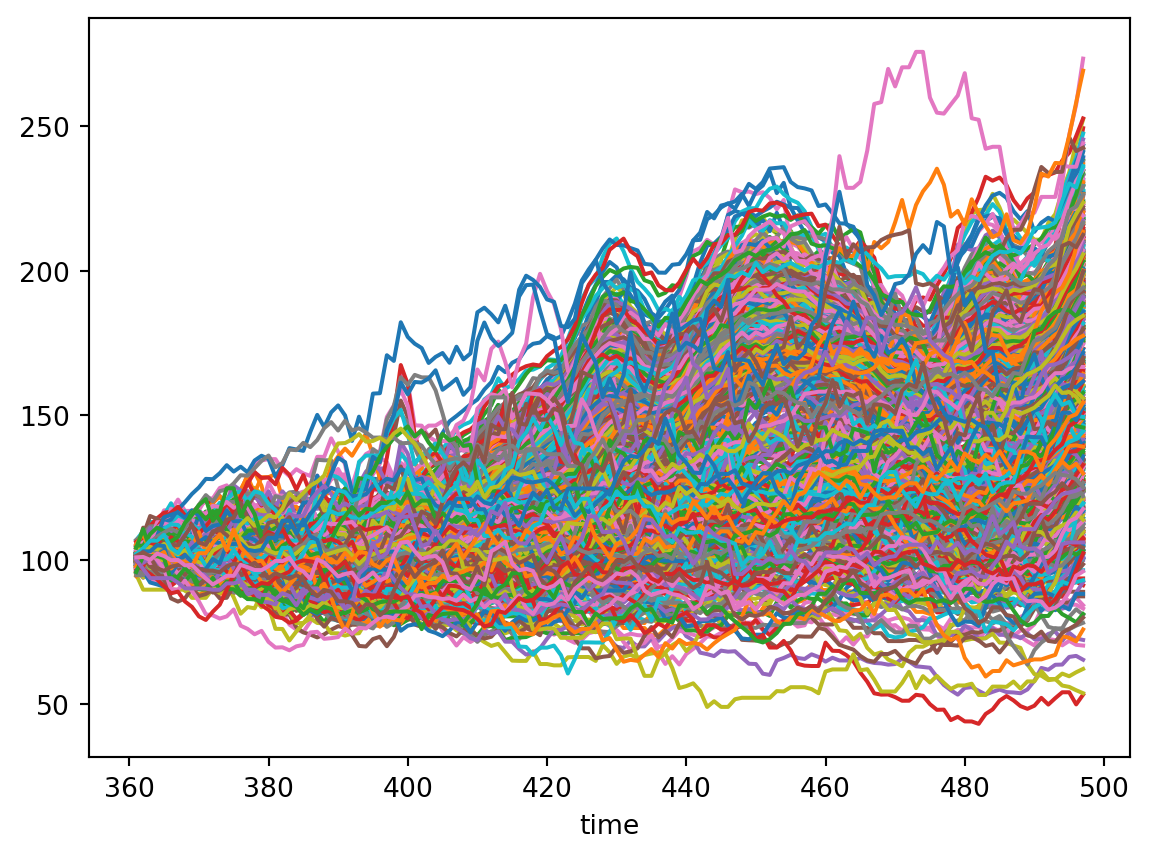

In [8]:
#| label: plot-before
df.groupby("postcode").plot(x="time", y="HPI", legend=False, ax=plt.gca());

In [9]:
#| label: remove-repeated-value-postcodes
# TODO

In [10]:
sorted(np.unique(df["sa4_name16"]))

['Capital Region',
 'Central Coast',
 'Central West',
 'Coffs Harbour - Grafton',
 'Far West and Orana',
 'Hunter Valley exc Newcastle',
 'Illawarra',
 'Mid North Coast',
 'Murray',
 'New England and North West',
 'Newcastle and Lake Macquarie',
 'Richmond - Tweed',
 'Riverina',
 'Southern Highlands and Shoalhaven',
 'Sydney - Baulkham Hills and Hawkesbury',
 'Sydney - Blacktown',
 'Sydney - City and Inner South',
 'Sydney - Eastern Suburbs',
 'Sydney - Inner South West',
 'Sydney - Inner West',
 'Sydney - North Sydney and Hornsby',
 'Sydney - Northern Beaches',
 'Sydney - Outer South West',
 'Sydney - Outer West and Blue Mountains',
 'Sydney - Parramatta',
 'Sydney - Ryde',
 'Sydney - South West',
 'Sydney - Sutherland']

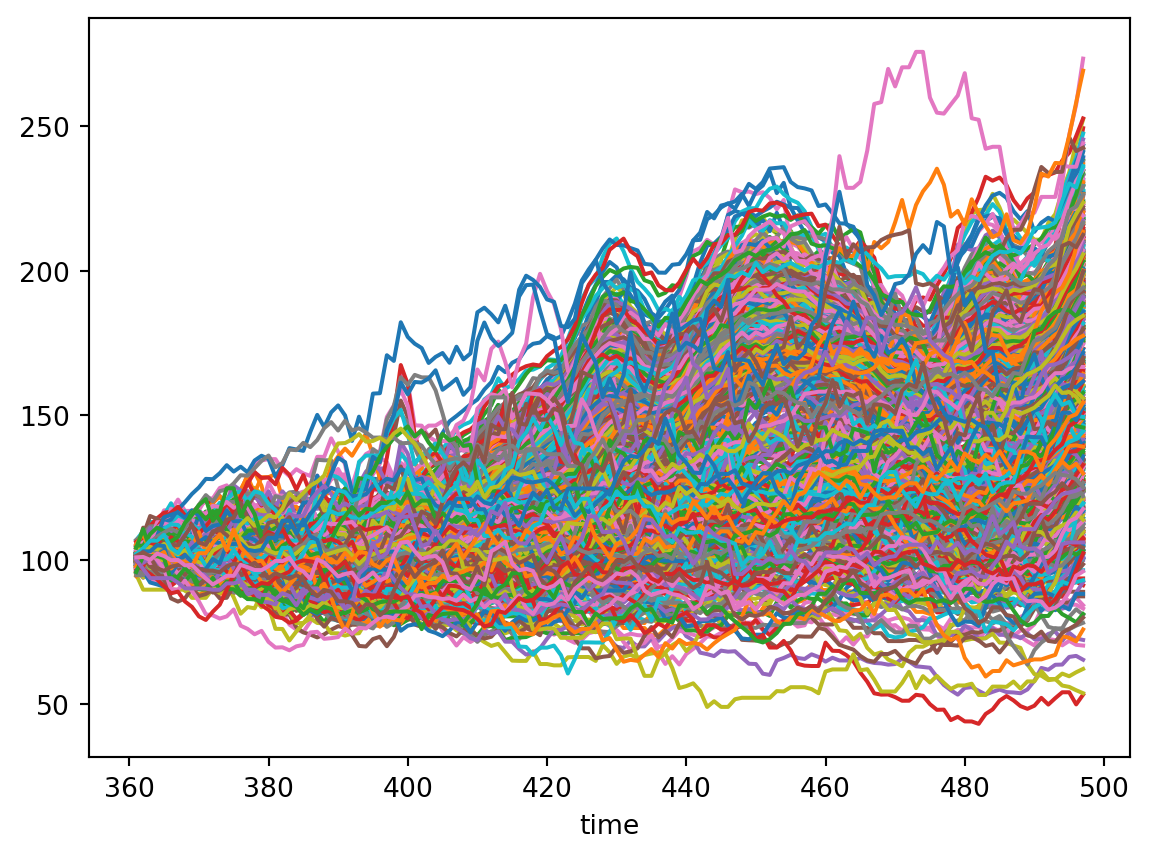

In [11]:
#| label: plot-hpi
df.groupby("postcode").plot(x="time", y="HPI", legend=False, ax=plt.gca());

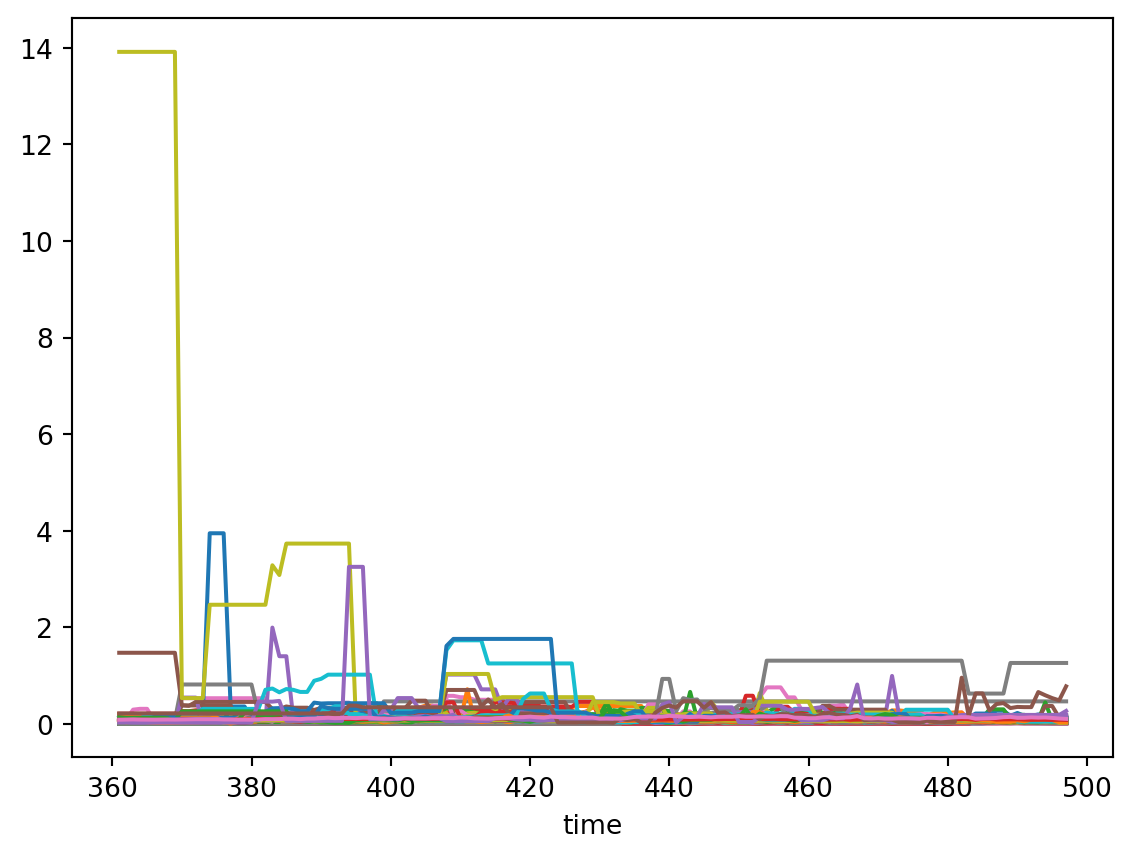

In [12]:
#| label: plot-yield
df.groupby("postcode").plot(x="time", y="Hedonic Rental Yields", legend=False, ax=plt.gca());

In [13]:
#| label: rescale
hpi_start_values = df.groupby("postcode").first()["HPI"]

for postcode in hpi_start_values.index:
	df.loc[df["postcode"] == postcode, "HPI"] *= 1 / hpi_start_values[postcode] * 100

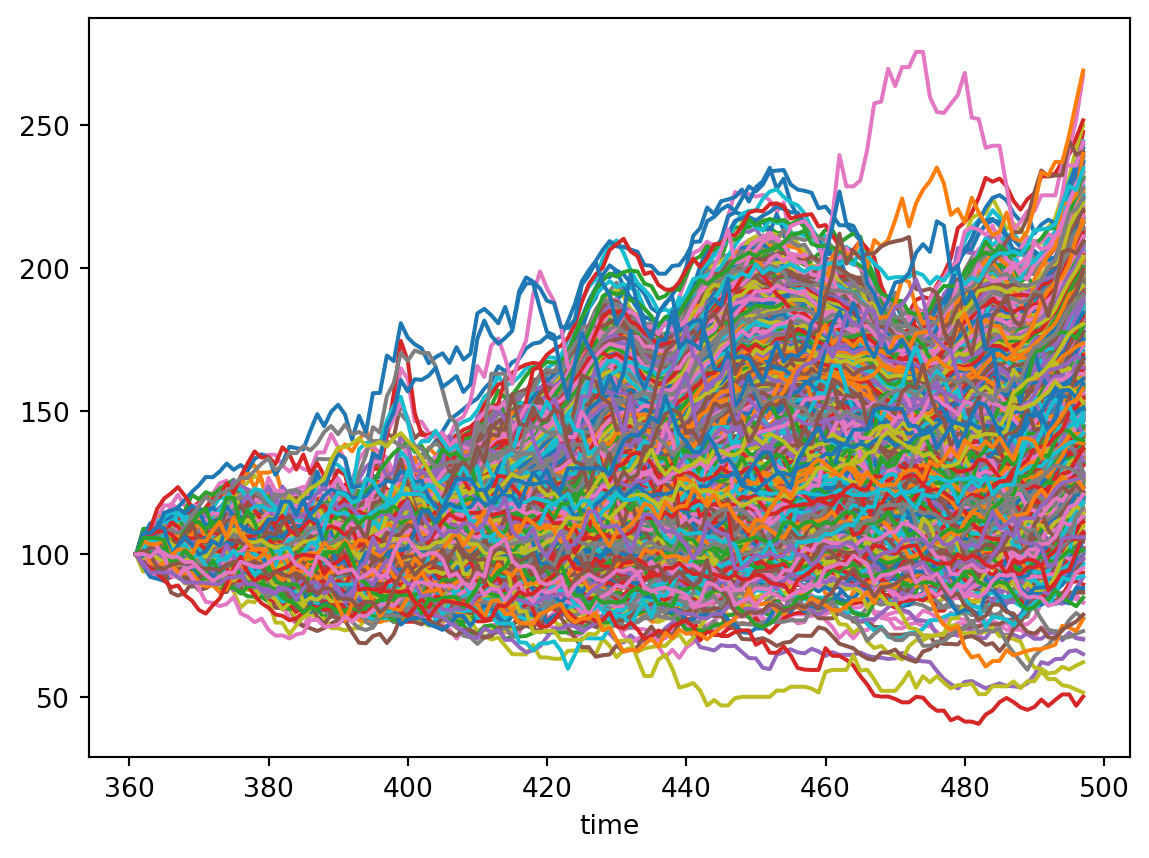

In [14]:
#| label: plot-rescaled
df.groupby("postcode").plot(x="time", y="HPI", legend=False, ax=plt.gca());

In [15]:
#| label: check-scaled-five-years-out
pws = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, float("inf")]
rhos = np.zeros_like(pws)

df[["HPI_norm"]] = (df[["HPI"]] - df[["HPI"]].mean()) / df[["HPI"]].std()

for i, pw in enumerate(pws):
  t = df["time"]
  x = df["HPI_norm"]
  panel = df["postcode"]
  res = edm(t, x, panel = panel,
    panelWeight = pw, p = 5 * 12,
	predictWithPast = True,
    numThreads = NUM_THREADS,
    full = True,
	showProgressBar=False,
	verbosity = 0,
  )
  rhos[i] = res["summary"]["rho"]

pd.DataFrame({"panelWeight": pws, "rho": rhos})

,panelWeight,rho
0,0.000,0.572459
1,0.001,0.589561
2,0.010,0.613168
3,0.100,0.644163
4,1.000,0.728524
5,10.000,0.810509
6,100.000,0.823078
7,1000.000,0.823643
8,10000.000,0.823643
9,inf,0.838611


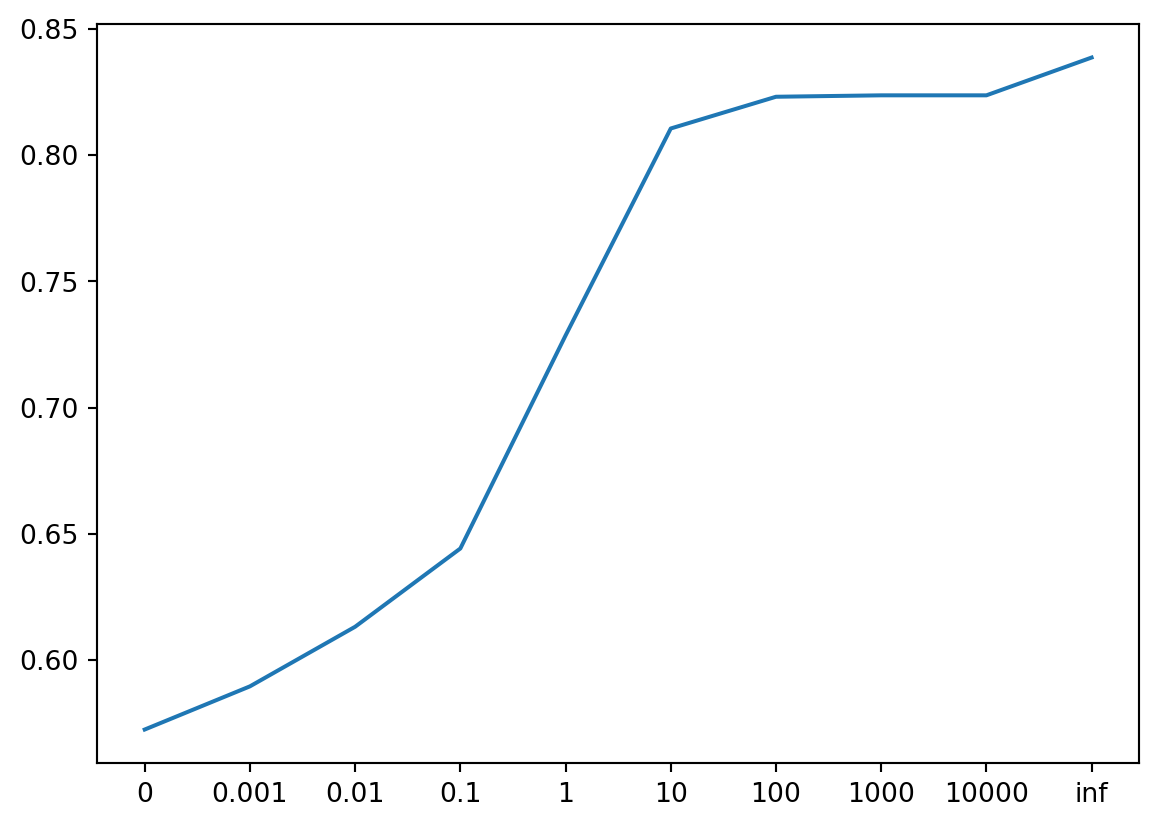

In [16]:
plt.plot(rhos)
plt.xticks(list(range(len(pws))), pws);

In [17]:
t = df["time"]
x = df["HPI_norm"]
panel = df["postcode"]

res = edm(t, x, panel = panel,
	panelWeight = float("inf"), p = 5 * 12,
	predictWithPast = True,
	numThreads = NUM_THREADS,
	full = True,
	showProgressBar=False,
	saveTargets=True,
	savePredictions=True,
	saveManifolds=True,
	verbosity = 0,
)

0.8386114885852475


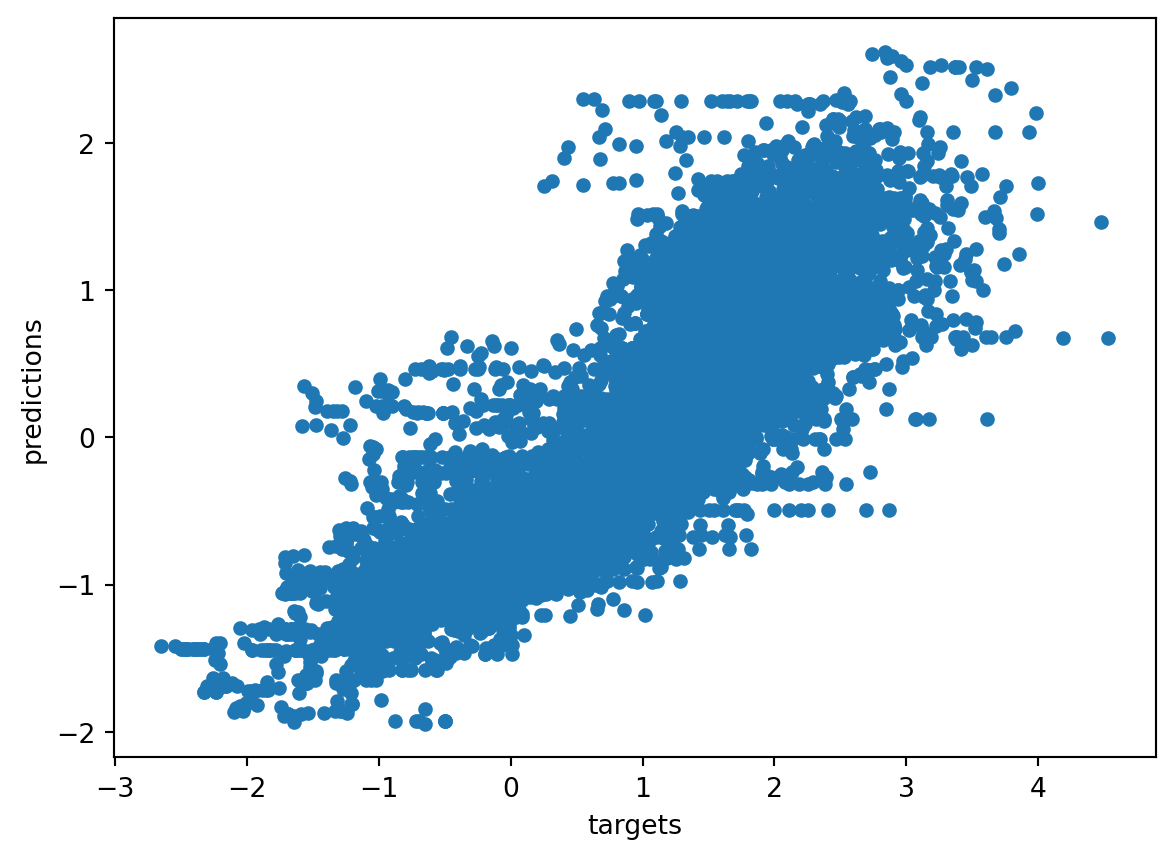

In [18]:
preds = pd.DataFrame({"targets": res["targets"].flatten(), "predictions": res["predictions"].flatten()})
preds = preds.dropna()
print(np.corrcoef(preds["targets"], preds["predictions"])[0,1])
preds.plot.scatter("targets", "predictions");

In [19]:
# yearAgo = res["Mps"][0][:,0]

# preds = pd.DataFrame({"targets": res["targets"].flatten(), "baseline-predictions": yearAgo})
# preds = preds.dropna()
# print(np.corrcoef(preds["targets"], preds["baseline-predictions"])[0,1])
# preds.plot.scatter("targets", "baseline-predictions");